In [113]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split


In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
df_test = pd.read_csv('/content/drive/MyDrive/MLQL/final_merged_data_take_2.csv')

Show the values that are not filled. We have 278 NAN values for values -> energy. Fix it if we have time. Should be named values_energy instead of values

In [116]:
nan_values_per_column = df_test.isna().sum()

print(nan_values_per_column)

X (rad/s)                      1
Y (rad/s)                      1
Z (rad/s)                      1
Activity                       0
Timestamp                      0
X (m/s^2)                      0
Y (m/s^2)                      0
Z (m/s^2)                      0
Latitude (°)                   6
Longitude (°)                  6
Height (m)                     6
Velocity (m/s)             12089
Direction (°)              21040
Horizontal Accuracy (m)        6
Vertical Accuracy (°)          6
dtype: int64


In [117]:
import pandas as pd
import numpy as np

df_test = df_test.fillna(0)

In [118]:
nan_values_per_column = df_test.isna().sum()

print(nan_values_per_column)

X (rad/s)                  0
Y (rad/s)                  0
Z (rad/s)                  0
Activity                   0
Timestamp                  0
X (m/s^2)                  0
Y (m/s^2)                  0
Z (m/s^2)                  0
Latitude (°)               0
Longitude (°)              0
Height (m)                 0
Velocity (m/s)             0
Direction (°)              0
Horizontal Accuracy (m)    0
Vertical Accuracy (°)      0
dtype: int64


In [119]:
df_test.describe()

,X (rad/s),Y (rad/s),Z (rad/s),X (m/s^2),Y (m/s^2),Z (m/s^2),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (°)
count,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000
mean,-0.009017,-0.009905,-0.005734,-0.789975,-2.748833,3.780022,52.327103,4.850919,-1.042767,0.539923,63.388116,22.414428,8.900040
std,1.620865,1.822340,0.760902,4.485930,8.918035,8.439468,0.742939,0.075555,1.749634,1.240547,104.505691,16.104979,7.954235
min,-9.186302,-21.547781,-7.549074,-63.166694,-57.845110,-31.064751,0.000000,0.000000,-4.883945,0.000000,0.000000,0.000000,0.000000
25%,-0.343019,-0.147134,-0.181014,-1.006657,-8.349337,-1.529220,52.320519,4.804530,-2.570389,0.000000,0.000000,4.772279,1.684861
50%,-0.000124,0.000371,0.000009,0.004384,-1.072220,0.760119,52.320521,4.871572,-1.816696,0.000000,0.000000,35.000000,3.372274
75%,0.235448,0.219427,0.191079,0.896186,3.113825,9.718091,52.377193,4.872530,1.104760,0.464447,151.405714,35.000000,18.054880
max,8.972337,20.000378,6.353308,21.938229,41.387584,104.114044,52.380508,4.872643,4.836160,8.446164,359.814396,200.000000,128.786972


In [120]:
df = df_test.copy(deep=True)

In [121]:
import pandas as pd

unique_activities = df['Activity'].unique()
print("Unique Activity Values:")
print(unique_activities)

Unique Activity Values:
['biking' 'running' 'sitting' 'standing' 'walking']


Train a NN that uses the data from Speed in order to predict the values for the energy missing. The 278 values mentioned above

In [122]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
df['Activity_encoded'] = label_encoder.fit_transform(df['Activity'])

X = df[['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)', 'X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)',
        'Latitude (°)', 'Longitude (°)', 'Height (m)', 'Velocity (m/s)',
        'Direction (°)', 'Horizontal Accuracy (m)', 'Vertical Accuracy (°)']].values
y = df['Activity_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
num_classes = len(label_encoder.classes_)

model = SimpleNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_model(model, train_loader, criterion, optimizer, epochs=5)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

predicted = predicted.numpy()
accuracy = (predicted == y_test).sum() / len(y_test)
print(f'Accuracy on test set: {accuracy:.4f}')


Epoch [1/5], Loss: 0.0155
Epoch [2/5], Loss: 0.0305
Epoch [3/5], Loss: 0.0039
Epoch [4/5], Loss: 0.1250
Epoch [5/5], Loss: 0.0041
Accuracy on test set: 0.9864


In [123]:
print(predicted)

[2 4 4 ... 4 1 1]


In [124]:
df.head()

,X (rad/s),Y (rad/s),Z (rad/s),Activity,Timestamp,X (m/s^2),Y (m/s^2),Z (m/s^2),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (°),Activity_encoded
0,-0.005521,0.000843,-0.049668,biking,2024-06-16 16:07:32.260251292+02:00,-1.578318,5.744754,7.943681,52.377219,4.803049,0.772721,0.033231,0.0,4.68123,3.451177,0
1,-0.016271,-0.019439,-0.044985,biking,2024-06-16 16:07:32.369187042+02:00,-1.990561,5.385351,7.889643,52.377219,4.803049,0.772721,0.033231,0.0,4.68123,3.451177,0
2,-0.004071,0.009880,0.016677,biking,2024-06-16 16:07:32.577807792+02:00,-1.647324,5.413942,8.045918,52.377219,4.803049,0.772721,0.033231,0.0,4.68123,3.451177,0
3,-0.005396,0.008447,-0.009898,biking,2024-06-16 16:07:32.886113542+02:00,-1.674717,5.359305,8.042326,52.377219,4.803049,0.772721,0.033231,0.0,4.68123,3.451177,0
4,-0.005247,0.003708,-0.052898,biking,2024-06-16 16:07:33.294104292+02:00,-1.818119,5.362149,8.056846,52.377219,4.803049,0.772721,0.033231,0.0,4.68123,3.451177,0


PEarson and SPearman corellation matrices to check which of the columns are very close to each other.

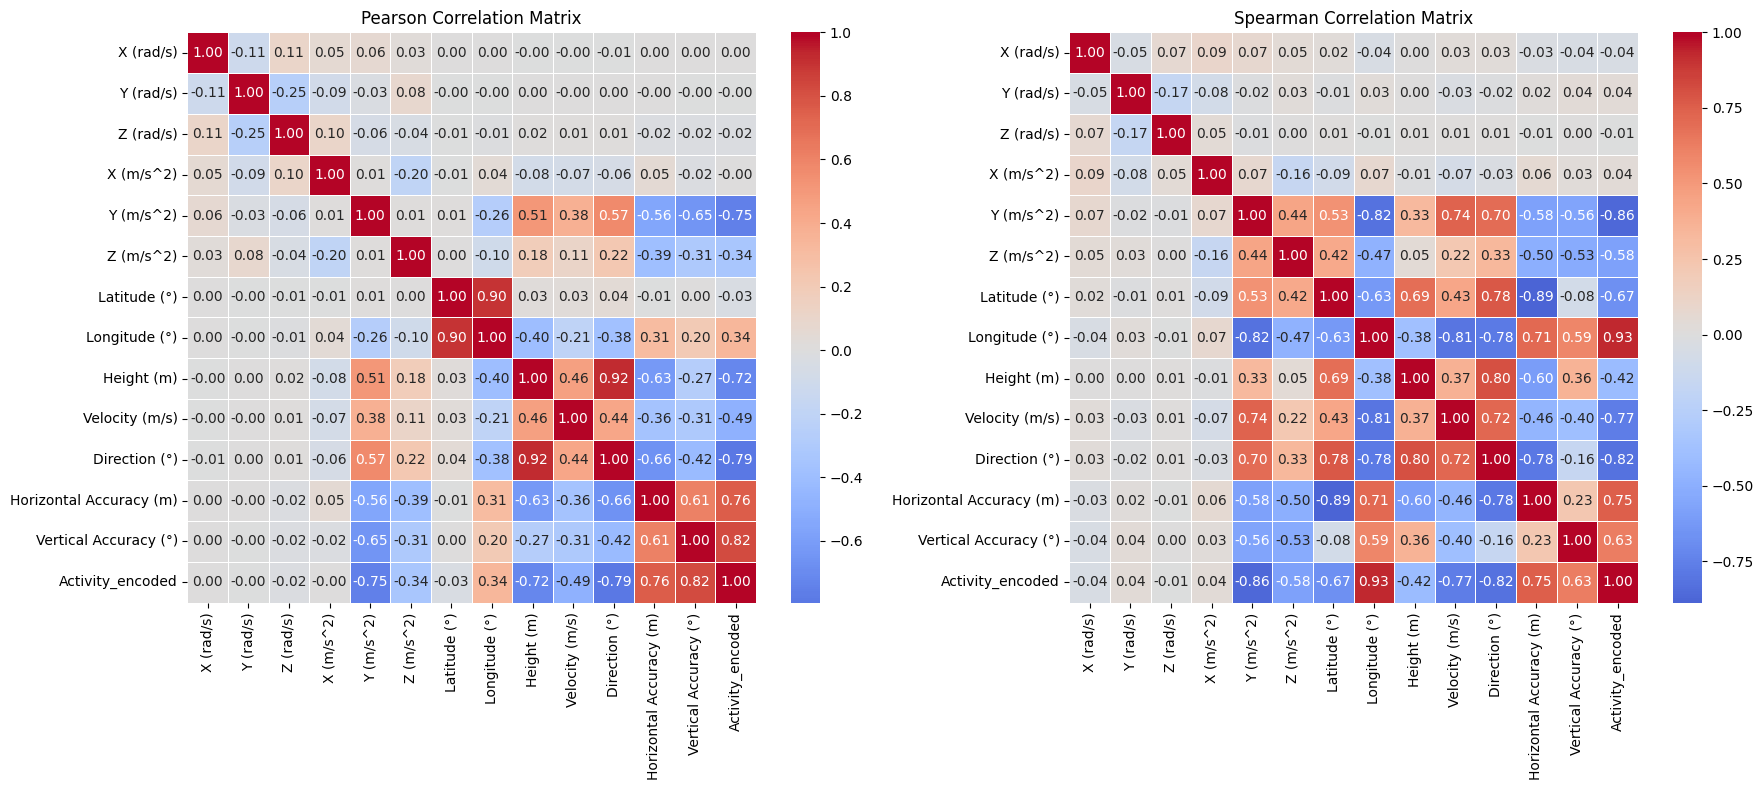

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label_encoder = LabelEncoder()
df['Activity_encoded'] = label_encoder.fit_transform(df['Activity'])
df = df.drop(columns=['Activity', 'Timestamp'])

correlation_matrix = df.corr()
spearman_corr = df.corr(method='spearman')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')

sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')

plt.tight_layout()
plt.show()

In [126]:
df.describe()

,X (rad/s),Y (rad/s),Z (rad/s),X (m/s^2),Y (m/s^2),Z (m/s^2),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (°),Activity_encoded
count,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000,29809.000000
mean,-0.009017,-0.009905,-0.005734,-0.789975,-2.748833,3.780022,52.327103,4.850919,-1.042767,0.539923,63.388116,22.414428,8.900040,2.328693
std,1.620865,1.822340,0.760902,4.485930,8.918035,8.439468,0.742939,0.075555,1.749634,1.240547,104.505691,16.104979,7.954235,1.540357
min,-9.186302,-21.547781,-7.549074,-63.166694,-57.845110,-31.064751,0.000000,0.000000,-4.883945,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.343019,-0.147134,-0.181014,-1.006657,-8.349337,-1.529220,52.320519,4.804530,-2.570389,0.000000,0.000000,4.772279,1.684861,1.000000
50%,-0.000124,0.000371,0.000009,0.004384,-1.072220,0.760119,52.320521,4.871572,-1.816696,0.000000,0.000000,35.000000,3.372274,2.000000
75%,0.235448,0.219427,0.191079,0.896186,3.113825,9.718091,52.377193,4.872530,1.104760,0.464447,151.405714,35.000000,18.054880,4.000000
max,8.972337,20.000378,6.353308,21.938229,41.387584,104.114044,52.380508,4.872643,4.836160,8.446164,359.814396,200.000000,128.786972,4.000000


In [127]:
import pandas as pd
import numpy as np

# Define Kalman filter function
def kalman_filter(data, process_variance, estimated_measurement_variance):
    n = len(data)
    xhat = np.zeros(n)      # a posteriori estimate of x
    P = np.zeros(n)         # a posteriori error estimate
    xhatminus = np.zeros(n) # a priori estimate of x
    Pminus = np.zeros(n)    # a priori error estimate
    K = np.zeros(n)         # gain or blending factor

    xhat[0] = data[0]
    P[0] = 1.0

    for k in range(1, n):
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + process_variance

        K[k] = Pminus[k] / (Pminus[k] + estimated_measurement_variance)
        xhat[k] = xhatminus[k] + K[k] * (data[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

process_variance = 1e-5
estimated_measurement_variance = 1e-1

filtered_df = df.copy()
columns_to_filter = ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)', 'X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)',
                     'Latitude (°)', 'Longitude (°)', 'Height (m)', 'Velocity (m/s)',
                     'Direction (°)', 'Horizontal Accuracy (m)', 'Vertical Accuracy (°)']

for column in columns_to_filter:
    filtered_values = kalman_filter(df[column].values, process_variance, estimated_measurement_variance)
    filtered_df[column] = filtered_values

removed_values = {}

for column in columns_to_filter:
    original_values = df[column].values
    filtered_values = filtered_df[column].values
    removed_values[column] = original_values[original_values != filtered_values]

removed_values_df = pd.DataFrame({k: pd.Series(v) for k, v in removed_values.items()})
print(removed_values_df.head())
removed_values_df.to_csv('kalman_filtered_df.csv', index=False)


   X (rad/s)  Y (rad/s)  Z (rad/s)  X (m/s^2)  Y (m/s^2)  Z (m/s^2)  \
0  -0.016271  -0.019439  -0.044985  -1.990561   5.385351   7.889643   
1  -0.004071   0.009880   0.016677  -1.647324   5.413942   8.045918   
2  -0.005396   0.008447  -0.009898  -1.674717   5.359305   8.042326   
3  -0.005247   0.003708  -0.052898  -1.818119   5.362149   8.056846   
4   0.007748  -0.005958  -0.054813  -1.992656   5.145400   8.049062   

   Latitude (°)  Longitude (°)  Height (m)  Velocity (m/s)  Direction (°)  \
0     52.377913       4.802122    3.590775        0.000000      65.009583   
1     52.377913       4.802122    3.590775        0.000000      65.009583   
2     52.377913       4.802122    3.590775        0.000000      65.009583   
3     52.377280       4.802967    4.836160        1.327296      49.877887   
4     52.377280       4.802967    4.836160        1.327296      49.877887   

   Horizontal Accuracy (m)  Vertical Accuracy (°)  
0                 5.904574              20.008459  
1     

Show the before and after appllying the kalman filter

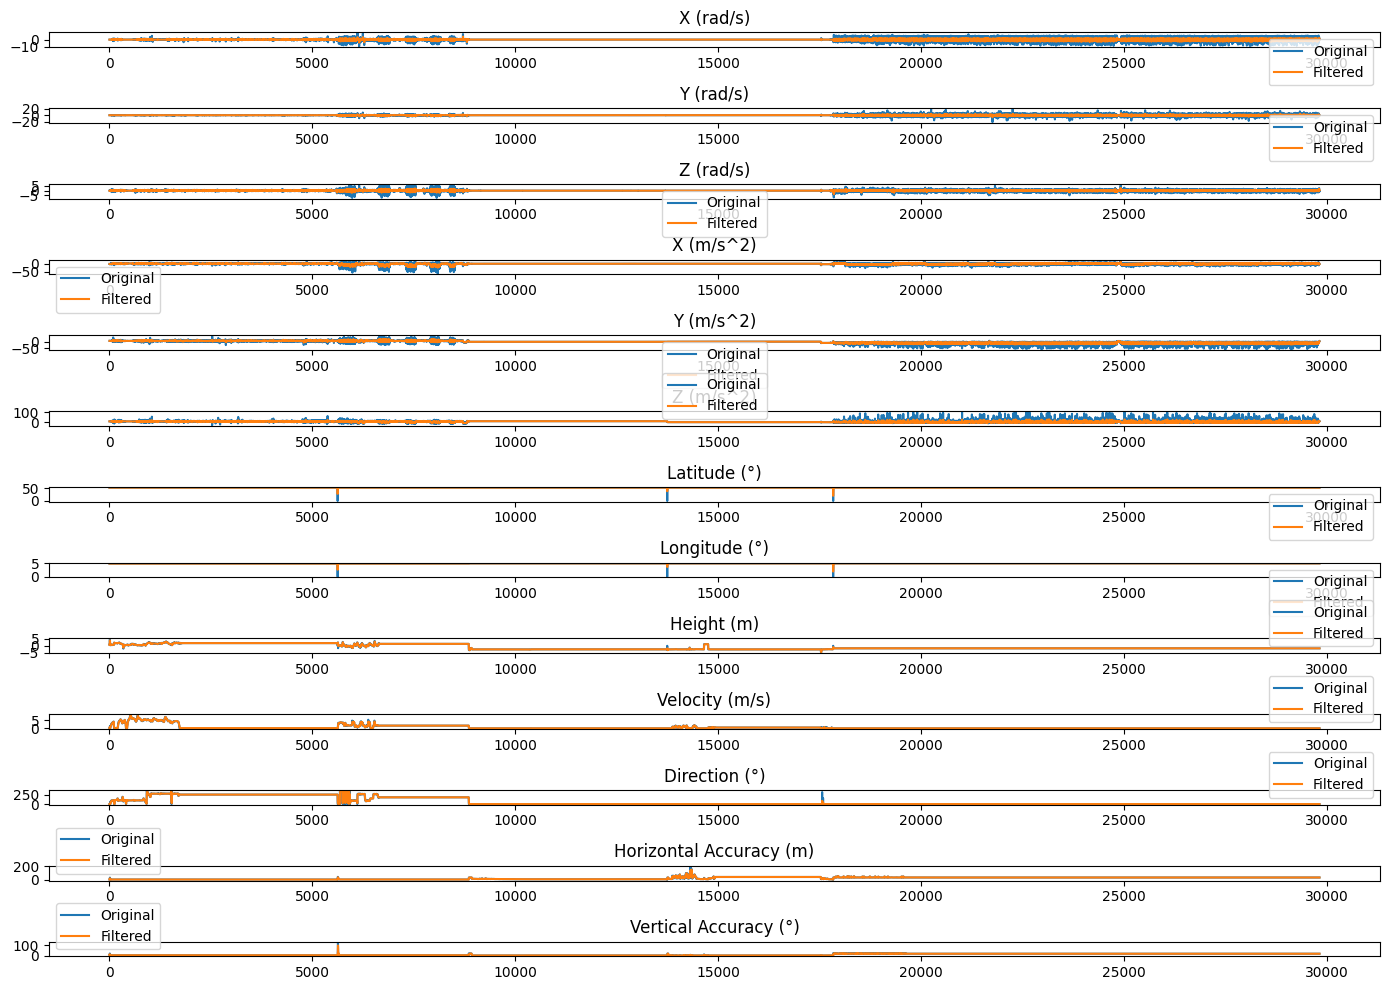

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def kalman_filter(data, process_variance, estimated_measurement_variance):
    n = len(data)
    xhat = np.zeros(n)      # a posteriori estimate of x
    P = np.zeros(n)         # a posteriori error estimate
    xhatminus = np.zeros(n) # a priori estimate of x
    Pminus = np.zeros(n)    # a priori error estimate
    K = np.zeros(n)         # gain or blending factor

    xhat[0] = data[0]
    P[0] = 1.0

    for k in range(1, n):
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + process_variance

        K[k] = Pminus[k] / (Pminus[k] + estimated_measurement_variance)
        xhat[k] = xhatminus[k] + K[k] * (data[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

process_variance = 1e-3
estimated_measurement_variance = 1e-2

filtered_df = df.copy()
columns_to_filter = ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)', 'X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)',
                     'Latitude (°)', 'Longitude (°)', 'Height (m)', 'Velocity (m/s)',
                     'Direction (°)', 'Horizontal Accuracy (m)', 'Vertical Accuracy (°)']

for column in columns_to_filter:
    filtered_values = kalman_filter(df[column].values, process_variance, estimated_measurement_variance)
    filtered_df[column] = filtered_values

plt.figure(figsize=(14, 10))

for i, column in enumerate(columns_to_filter, 1):
    plt.subplot(len(columns_to_filter), 1, i)
    plt.plot(df.index, df[column], label='Original')
    plt.plot(df.index, filtered_df[column], label='Filtered')
    plt.title(column)
    plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-138-e89ed1b4dea1>:33: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


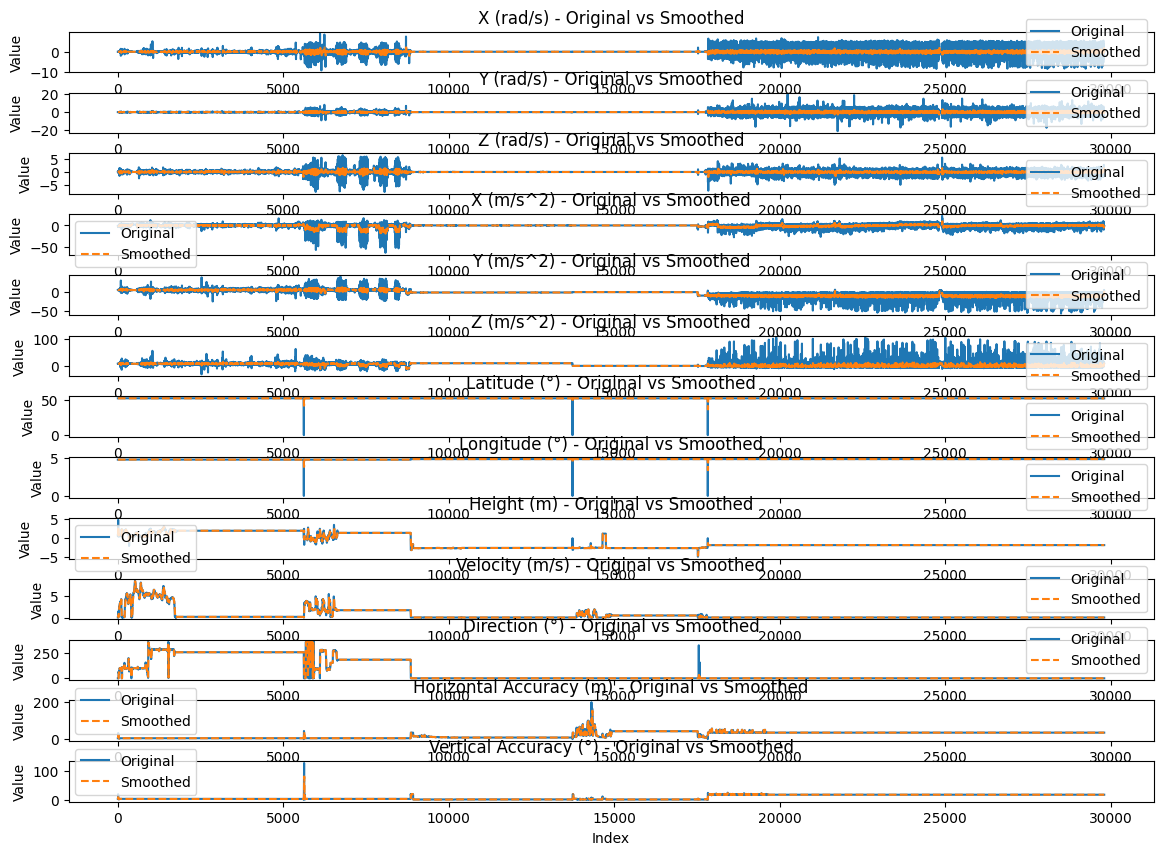

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def sliding_window_mean(data, window_size=10):
    smoothed = np.zeros_like(data)
    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        smoothed[i] = np.mean(data[start_idx:i+1])
    return data, smoothed

columns_to_smooth = ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)',
                     'X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)',
                     'Latitude (°)', 'Longitude (°)', 'Height (m)',
                     'Velocity (m/s)', 'Direction (°)',
                     'Horizontal Accuracy (m)', 'Vertical Accuracy (°)']

plt.figure(figsize=(14, 10))

plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(columns_to_smooth, 1):
    original, smoothed = sliding_window_mean(df[col].values, window_size=10)
    plt.subplot(len(columns_to_smooth), 1, i)
    plt.plot(original, label='Original')
    plt.plot(smoothed, label='Smoothed', linestyle='--')
    plt.title(f'{col} - Original vs Smoothed')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()


In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = df.drop(columns=['Activity_encoded'])
y = df['Activity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1106
           1       1.00      1.00      1.00       637
           2       1.00      1.00      1.00      1757
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00      2402

    accuracy                           1.00      5962
   macro avg       1.00      1.00      1.00      5962
weighted avg       1.00      1.00      1.00      5962

Accuracy: 1.0000


In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(df['Activity_encoded'].unique())

lstm_model = LSTMModel(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

def train_lstm(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_lstm(lstm_model, train_loader, criterion, optimizer, epochs=10)

lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = torch.argmax(lstm_model(X_test_tensor.unsqueeze(1)), dim=1).numpy()

print("\nLSTM Model:")
print(classification_report(y_test, y_pred_lstm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lstm):.4f}")


Epoch [1/10], Loss: 0.4938
Epoch [2/10], Loss: 0.0171
Epoch [3/10], Loss: 0.0119
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0065
Epoch [6/10], Loss: 0.0148
Epoch [7/10], Loss: 0.0023
Epoch [8/10], Loss: 0.0062
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0083

LSTM Model:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1106
           1       0.99      0.93      0.96       637
           2       1.00      1.00      1.00      1757
           3       1.00      0.98      0.99        60
           4       1.00      1.00      1.00      2402

    accuracy                           0.99      5962
   macro avg       0.99      0.98      0.99      5962
weighted avg       0.99      0.99      0.99      5962

Accuracy: 0.9918


In [132]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm_classifier.fit(X_train, y_train)
y_pred_gbm = gbm_classifier.predict(X_test)

print("Gradient Boosting Machine:")
print(classification_report(y_test, y_pred_gbm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_gbm):.4f}")


Gradient Boosting Machine:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1106
           1       1.00      1.00      1.00       637
           2       1.00      1.00      1.00      1757
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00      2402

    accuracy                           1.00      5962
   macro avg       1.00      1.00      1.00      5962
weighted avg       1.00      1.00      1.00      5962

Accuracy: 0.9998


In [134]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale'))

svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

print("Support Vector Machine (SVM):")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")


Support Vector Machine (SVM):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1106
           1       0.98      0.96      0.97       637
           2       1.00      0.99      1.00      1757
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00      2402

    accuracy                           0.99      5962
   macro avg       0.99      0.99      0.99      5962
weighted avg       0.99      0.99      0.99      5962

Accuracy: 0.9918
